In [28]:
import os
from pathlib import Path
from typing import Callable
import warnings

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from segregation.aspatial import Dissim, MinMax
import rasterio as rio
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

data_dir = Path('../data')
YEARS = [1880, 1885, 1888, 1890, 1895, 1900, 1902, 1905, 1910, 1913, 1915]
BAD_YEARS = [1885, 1890, 1905, 1910]
BWS = 150, 200, 250
CELL_SIZE = 20

In [29]:

def get_xy(
        geodf: gpd.GeoDataFrame,
        geometry_col: str = None,
) -> gpd.GeoDataFrame:

    if not geometry_col:
        geometry_col = geodf.geometry.name

    if geodf[geometry_col].geom_type[0] == 'Point':
        geodf['x'] = geodf[geometry_col].apply(lambda geom: geom.x)
        geodf['y'] = geodf[geometry_col].apply(lambda geom: geom.y)
    else:
        geodf['x'] = geodf[geometry_col].apply(lambda geom: tuple(geom.exterior.coords.xy[0]))
        geodf['y'] = geodf[geometry_col].apply(lambda geom: tuple(geom.exterior.coords.xy[1]))
    return geodf


def kernel_density_surface(
        data: gpd.GeoDataFrame,
        group: str,
        bandwidth,
        cell_size,
        kernel_function: Callable,
):
    pop = get_xy(data)
    pad = 0

    minx, miny, maxx, maxy = pop.geometry.total_bounds

    minx -= pad
    miny -= pad
    maxx += pad
    maxy += pad

    x = np.arange(minx, maxx, cell_size)
    y = np.arange(miny, maxy, cell_size)

    X, Y = np.meshgrid(x, y)

    xy = np.vstack([Y.ravel(), X.ravel()]).T

    U = cdist(xy, pop[['y', 'x']].values, metric='euclidean')
    W = kernel_function(U, bandwidth=bandwidth)

    density = (W * pop[group].values).sum(axis=1).reshape(X.shape)

    geotiff_meta = {
        'driver': 'GTiff',
        'count': 1,
        'dtype': density.dtype,
        'width': density.shape[1],
        'height': density.shape[0],
        'crs': data.crs,
        'transform': rio.transform.from_bounds(
            west=minx,
            east=maxx,
            north=maxy,
            south=miny,
            width=len(x),
            height=len(y),
        )
    }

    return density[::-1, ], geotiff_meta


def get_S(
        data,
        **kwargs
):
    if data.empty:
        return None

    density_total, _ = kernel_density_surface(
        data,
        group='total',
        **kwargs
    )
    density_orthodox, _ = kernel_density_surface(
        data,
        group='orthodox',
        **kwargs
    )

    density = pd.DataFrame({
            'orthodox': density_orthodox.flatten(),
            'total': density_total.flatten(),
         })
    S = MinMax(density, 'orthodox', 'total')

    return S


In [30]:

def remove_institutions(
        pop_data: pd.DataFrame,
        institutions: pd.DataFrame,
        year,
):
    institutions = institutions.set_index(['district', 'plot_number'])
    institutions = institutions.loc[institutions.year == year]

    for idx in institutions.index:
        pop_data = pop_data.drop(index=idx, errors='ignore')

    return pop_data


def handle_combined_plots(
        pop_data: pd.DataFrame,
        target_column: str = 'plot_number',
):
    target_shape = pop_data.shape
    index_columns = pop_data.index.names
    pop_data.reset_index(inplace=True)
    pop_data[target_column] = [e.split(',')[0].strip() for e in pop_data[target_column]]
    pop_data.set_index(index_columns, inplace=True)

    assert pop_data.shape == target_shape

    return pop_data


def prepare_pop_data(
        population_data: pd.DataFrame,
        num_cols=None,
) -> pd.DataFrame:

    pop_frame = population_data.fillna(value=0)

    if not num_cols:
        num_cols = [
            'total_men',
            'total_women',
            'orthodox',
            'other_christian',
            'other_religion',
        ]

    pop_frame.loc[:, num_cols] = pop_frame.loc[:, num_cols].astype(int)

    pop_frame['lutheran'] = pop_frame['total_men total_women'.split()].sum(axis=1) \
                            - pop_frame['other_christian orthodox other_religion'.split()].sum(axis=1)

    pop_frame['total'] = pop_frame['other_christian orthodox other_religion lutheran'.split()].sum(axis=1)

    return pop_frame


In [31]:
def split_plots(
        geodataframe: gpd.GeoDataFrame,
        target_col: str,
        separator: str = ',',
) -> gpd.GeoDataFrame:

    new_geodataframe = gpd.GeoDataFrame(columns=geodataframe.columns)

    for _, row in geodataframe.iterrows():
        plots = str(row[target_col]).split(separator)

        if len(plots) < 2:
            new_geodataframe = new_geodataframe.append(row)
            continue

        for plot in plots:
            new_row = row
            new_row[target_col] = plot
            new_geodataframe = new_geodataframe.append(new_row)

    assert len(new_geodataframe.index) == len(list(pd.core.common.flatten(
        [
            str(w).split(separator)
            for w
            in geodataframe[target_col]
        ]))), 'splitting failed'

    return new_geodataframe.reindex()


In [32]:
def quartic_kernel(u, bandwidth):
    return np.where(
            np.abs(u) <= bandwidth,
            3 / (np.pi * bandwidth * bandwidth) * (1 - (u / bandwidth) ** 2) ** 2,
            0
    )

In [33]:
warnings.simplefilter(action='ignore', category=FutureWarning)

district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
institutions = pd.read_csv(data_dir / 'institutions.csv', dtype={'district': str, 'plot_number': str})

location_data = gpd.read_file(data_dir / 'raw' / 'plots_1878.gpkg').to_crs(epsg=3067)
location_data = split_plots(location_data, target_col='NUMBER')
location_data['district'] = [district_codes[int(d)] for d in location_data['DISTRICT']]
location_data['plot_number'] = [str(i) for i in location_data['NUMBER']]
location_data = location_data.set_index(['district', 'plot_number'])
city = gpd.read_file(data_dir / 'raw' / 'city_1846.shp').to_crs(epsg=3067)
location_data = location_data.loc[~location_data.geometry.within(city.geometry[0]).index.duplicated()]
location_data = location_data.loc[location_data.geometry.within(city.geometry[0])]

In [57]:
results_dict = {}
for year in YEARS:
    # if year in BAD_YEARS:
        # continue
    
    s_ = []
    for bw in BWS:
        population_data = pd.read_csv(
            data_dir / 'interim' / f'pop_by_page_{year}.csv',
            index_col=0,
            dtype={'district': str, 'representative_plot': str, 'page_number': str},
        ).pipe(prepare_pop_data)
        population_data.rename({'representative_plot': 'plot_number'}, axis=1, inplace=True)
        population_data = population_data.set_index(['district', 'plot_number'], drop=True)
        population_data = population_data.pipe(handle_combined_plots).pipe(remove_institutions, institutions, year)
        page_location_data = location_data.join(population_data, on=['district', 'plot_number'])
        page_location_data.dropna(axis=0, inplace=True)

        for group in 'orthodox', 'lutheran', 'total':
            file = data_dir / 'processed' / f"{group}_density_{year}_{bw}_m.tif"
            if file.exists():
                continue
            
            density, raster_args = kernel_density_surface(
                page_location_data,
                group=group,
                bandwidth=bw,
                cell_size=CELL_SIZE,
                kernel_function=quartic_kernel,
            )
            density = density * 10_000

            with rio.open(file, 'w', **raster_args) as rfile:
                rfile.write(density, 1)

        S = get_S(
            data=page_location_data,
            bandwidth=bw,
            cell_size=CELL_SIZE,
            kernel_function=quartic_kernel,
        )

        s_.append(S.statistic)

    results_dict[year] = s_

results = pd.DataFrame.from_dict(
    results_dict,
    orient='index',
    columns=BWS,
)

/tmp/ipykernel_3786/4003846893.py:46: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pop_frame.loc[:, num_cols] = pop_frame.loc[:, num_cols].astype(int)
/tmp/ipykernel_3786/4003846893.py:46: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pop_frame.loc[:, num_cols] = pop_frame.loc[:, num_cols].astype(int)
/tmp/ipykernel_3786/4003846893.py:46: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] =

/tmp/ipykernel_3786/4003846893.py:46: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pop_frame.loc[:, num_cols] = pop_frame.loc[:, num_cols].astype(int)
/tmp/ipykernel_3786/4003846893.py:46: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pop_frame.loc[:, num_cols] = pop_frame.loc[:, num_cols].astype(int)
/tmp/ipykernel_3786/4003846893.py:46: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] =

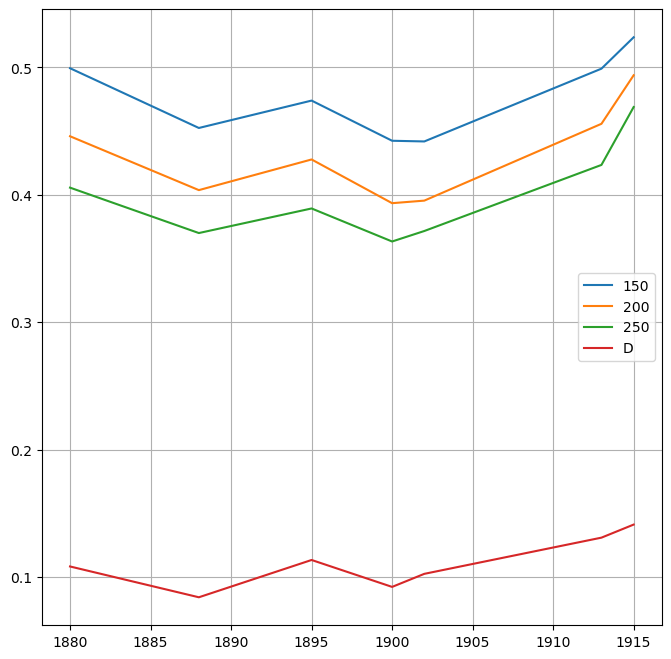

In [58]:
districts_in_city = [
    'Valli',
    'Salakkalahti',
    'Repola',
    'Anina',
    'Papula',
    'P_Annan_kruunu',
    'Hiekka',
    'Pantsarlahti',
    'Viipurin_esikaupunki',
    'Paulovski',
    'Havi',
    'Saunalahti',
    'Pietarin_esikaupunki',
]

results_D = {}

for year in YEARS:
    # if year in BAD_YEARS:
        # continue

    population_data = pd.read_csv(
            data_dir / 'interim' / f'pop_by_page_{year}.csv',
            index_col=0,
            dtype={'district': str, 'representative_plot': str, 'page_number': str},
        ).pipe(prepare_pop_data)
    population_data = population_data[population_data.district.isin(districts_in_city)]
    population_data = population_data.loc[:, ['district', 'lutheran', 'orthodox', 'total']].groupby('district').sum()
    totals = pd.Series(population_data.sum(axis=0), name='totals')
    population_data = population_data.append(totals)

    D = Dissim(
        population_data,
        group_pop_var='orthodox',
        total_pop_var='total',
    )
    results_D[year] = D.statistic

results['D'] = pd.Series(results_D)
results.to_csv(data_dir / 'processed' / 'results.csv')
results.drop(labels=BAD_YEARS, axis=0, inplace=True)
results.plot(
    figsize=(8, 8),
    subplots=False,
    grid=True,
)
# for ax in axes:
    # ticks = np.arange(0, 1, 0.05)
    # ax.set_yticks(ticks)
    # ax.autoscale_view()
plt.savefig('../figures/S_and_D.png')

In [59]:
# individual impact

def loo_data_generator(
    data: pd.DataFrame,
):
    for idx in data.index:
        clipped = data.drop(index=idx)
        yield idx, clipped

def individual_impact(
    data: pd.DataFrame,
    **kwargs
)-> pd.Series:
    S_normal = get_S(
        data=data,
        **kwargs
    )
    statistics = {}
    for (idx, clipped_data) in loo_data_generator(data):
        S = get_S(
            data=clipped_data,
            **kwargs
        )
        statistics[idx] = S.statistic
    impact = S_normal.statistic - pd.Series(statistics)
    impact.name = 'S'
    return impact.round(5)

In [60]:
results = {}
for year in YEARS:
    for bw in BWS:
        output_file = data_dir / 'processed' / f'S_impact_{year}_{bw}m.csv'
        if output_file.exists():
            continue
    
        population_data = pd.read_csv(
            data_dir / 'interim' / f'pop_by_page_{year}.csv',
            index_col=0,
            dtype={'district': str, 'representative_plot': str, 'page_number': str},
        ).pipe(prepare_pop_data)
        population_data.rename({'representative_plot': 'plot_number'}, axis=1, inplace=True)
        population_data = population_data.set_index(['district', 'plot_number'], drop=True)
        population_data = population_data.pipe(handle_combined_plots).pipe(remove_institutions, institutions, year)
        page_location_data = location_data.join(population_data, on=['district', 'plot_number'])
        page_location_data.dropna(axis=0, inplace=True)
        impact = individual_impact(
            page_location_data,
            bandwidth=bw,
            cell_size=CELL_SIZE,
            kernel_function=quartic_kernel,
        )
        impact.to_csv(output_file)


                         S_impact_1888_200m
Pantsarlahti         62            -0.00927
Salakkalahti         6             -0.00864
Viipurin_esikaupunki 28            -0.00840
                         S_impact_1888_200m
Valli                39             0.00628
Pietarin_esikaupunki 44             0.00772
                     7              0.00841

                          S_impact_1890_200m
Repola               1              -0.01082
Pietarin_esikaupunki 144            -0.00963
Repola               32             -0.00918
                         S_impact_1890_200m
Valli                92             0.00493
Pietarin_esikaupunki 44             0.00588
                     7              0.00808

                          S_impact_1895_200m
Pantsarlahti         73             -0.00968
Pietarin_esikaupunki 141            -0.00879
Viipurin_esikaupunki 44             -0.00785
            S_impact_1895_200m
Papula 30              0.00526
Valli  38              0.00560
       114      

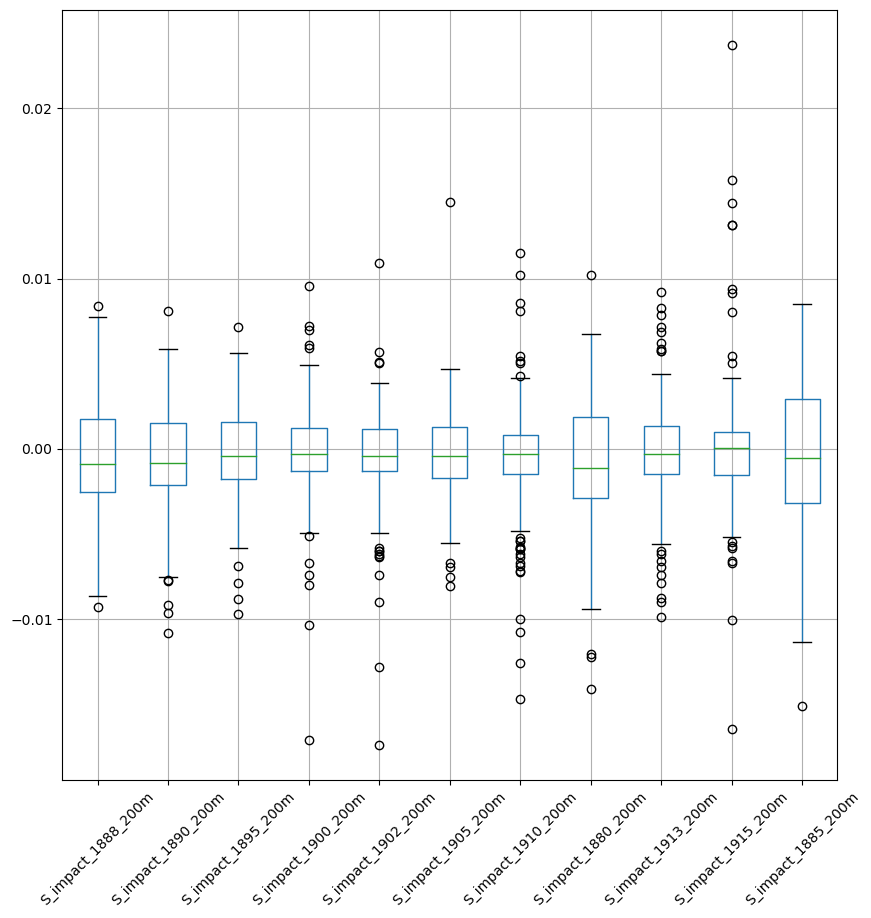

In [61]:
impact_list = []
for file in (data_dir / 'processed').glob('S_impact*200m.csv'):
    impact = pd.read_csv(file, index_col=(0, 1), header=0, names=[file.stem])
    sorted_ = impact.sort_values(by=file.stem)
    impact_list.append(sorted_)
    print()
    print(sorted_.head(3))
    print(sorted_.tail(3))

impacts = pd.concat(impact_list)
impacts.boxplot(rot=45, figsize=(10,10))
plt.show()

Text(0, 0.5, 'basis')

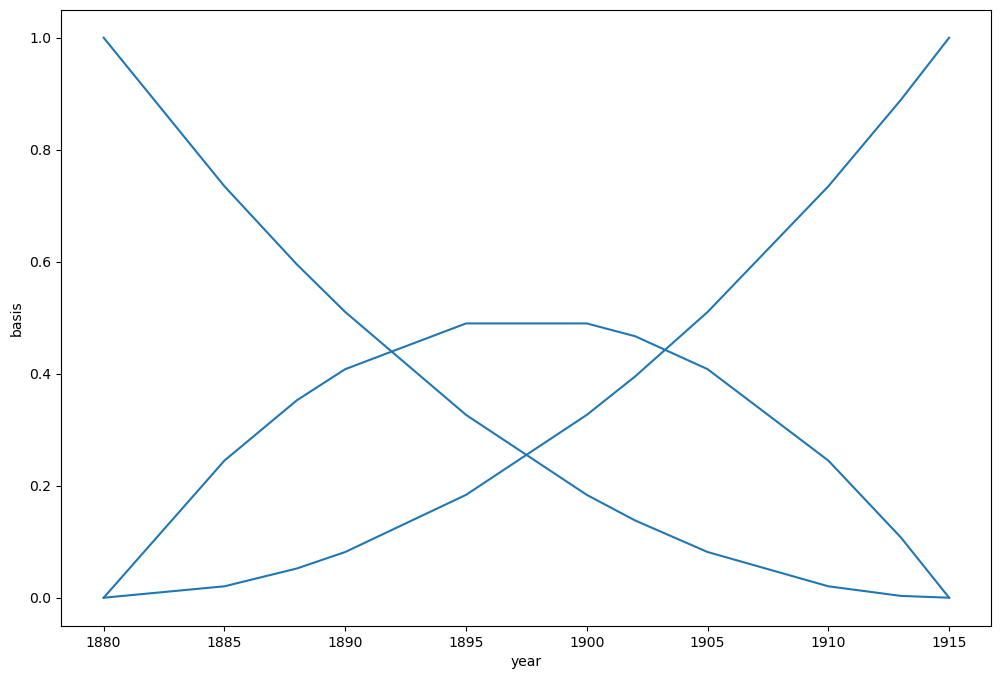

In [119]:
import arviz as az
import pymc as pm
from patsy import dmatrix

regression_data = pd.read_csv(data_dir / 'processed' / 'results.csv', index_col=0)
regression_data.loc[regression_data.index.isin(BAD_YEARS),:] = np.nan
n_knots = 2

knot_list = np.linspace(regression_data.index.min(), regression_data.index.max(), n_knots)
B = dmatrix(
    "bs(year, knots=knots, degree=2, include_intercept=True) - 1",
    {"year": regression_data.index, "knots": knot_list[1:-1]},
)

_, ax = plt.subplots(1, 1, figsize=(12, 8))
for i in range(n_knots + 1):
    ax.plot(regression_data.index, (B[:, i]), color="C0")
ax.set_xlabel("year")
ax.set_ylabel("basis")


In [120]:
mu_w = [0] * (n_knots + 1)
with pm.Model() as model:
    a = pm.Normal("a", 0.45, 0.01)
    w = pm.Normal("w", mu=mu_w, sigma=0.1, shape=B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    sigma = pm.HalfNormal("sigma", 0.1)
    S = pm.Normal("S", mu, sigma, observed=regression_data['200'])
    idata = pm.sample(1000, tune=1000, chains=5)


/home/antth/anaconda3/envs/spatial_segregation/lib/python3.11/site-packages/pymc/model.py:1400: ImputationWarning: Data in S contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [a, w, sigma, S_missing]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 20 seconds.


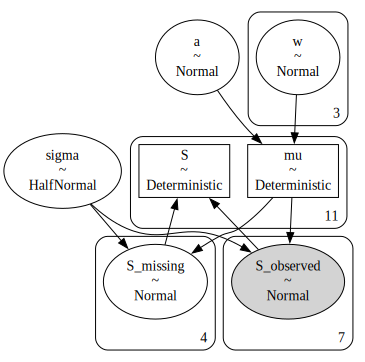

In [121]:
graph = pm.model_to_graphviz(model)
graph

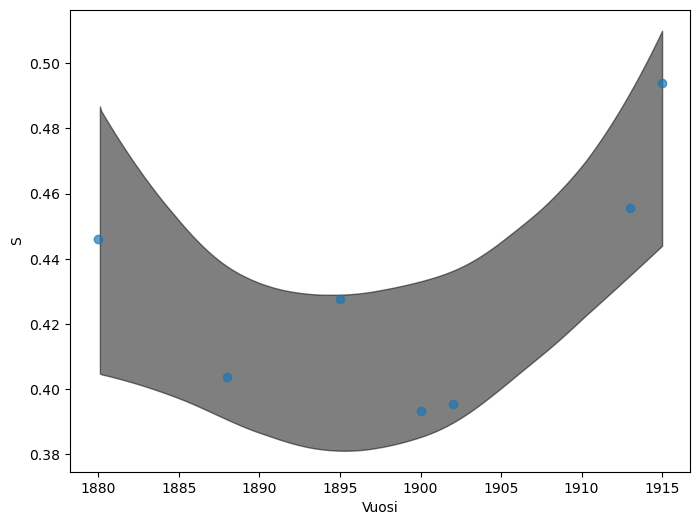

In [122]:
ax = az.plot_hdi(regression_data.index, idata["posterior"]["mu"], color="k", hdi_prob=0.9)
ax.plot(regression_data.index, regression_data["200"], "o", alpha=0.7)
fig = plt.gcf()
fig.set_size_inches(8, 6)
# ax.set_ylim(0, 1600)
ax.set_xlabel("Vuosi")
ax.set_ylabel("S")
plt.show()

In [123]:
# az.plot_posterior(idata, var_names="S")
# plt.show()

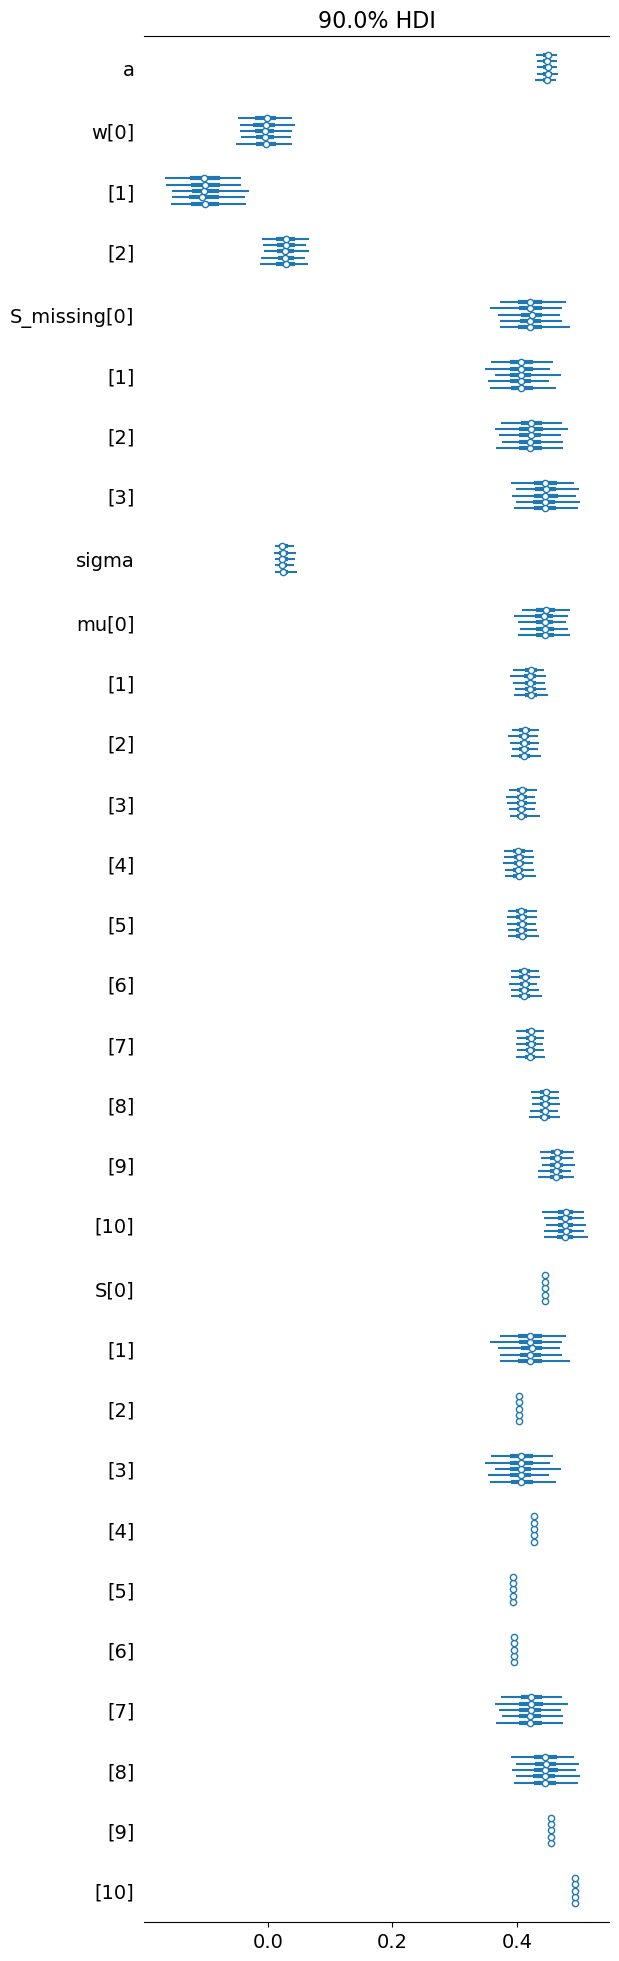

In [124]:
az.plot_forest(idata, hdi_prob=0.9, combined=False)
plt.show()

/home/antth/anaconda3/envs/spatial_segregation/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


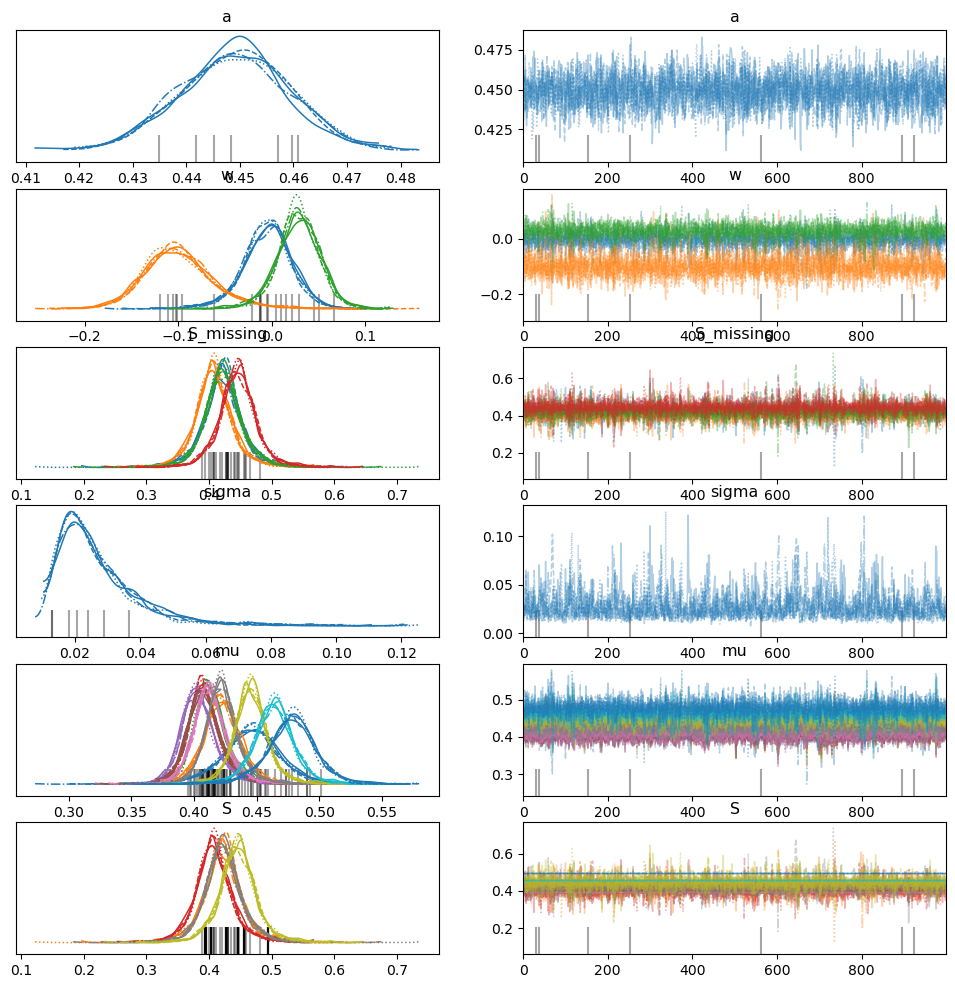

In [125]:
az.plot_trace(idata)
plt.show()